In [1]:
#Increase the Batch size Instead of reducing the learning rate

In [13]:
# Imports
import os
import time

import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.determinitic = True

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Model settings

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# OTHERS
DEVICE = "cuda:0"

In [16]:
# Dataset

train_indices = torch.arange(0, 48000)
valid_indices = torch.arange(48000, 50000)

train_transform = transforms.Compose([transforms.Resize((70,70)),
                                    transforms.RandomCrop((64, 64)),
                                    transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((70,70)),
                                   transforms.CenterCrop((64,64)),
                                   transforms.ToTensor()])

train_and_valid = datasets.CIFAR10(root='data',
                              train=True,
                              transform= train_transform,
                              download=True)


train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)
test_dataset = datasets.CIFAR10(root='data',
                               train= False,
                               transform = test_transform,
                               download = False)


train_loader = DataLoader(dataset=train_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=4,
                        shuffle=False)

Files already downloaded and verified


In [17]:
# checking the dataset
print('Training set:\n')
for images, labels in train_loader:
    print('Image Batch dimension:',images.size())
    print('Image label dimension:',labels.size())
    break
# checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimension',images.size())
    print('Image batch dimension', labels.size())
    break

# checking the dataset
print('\n Testing Set')
for images,labels in test_loader:
    print('Image batch dimension',images.size())
    print('labels batch dimension',labels.size())
    break

Training set:

Image Batch dimension: torch.Size([256, 3, 64, 64])
Image label dimension: torch.Size([256])

Validation Set:
Image batch dimension torch.Size([256, 3, 64, 64])
Image batch dimension torch.Size([256])

 Testing Set
Image batch dimension torch.Size([256, 3, 64, 64])
labels batch dimension torch.Size([256])


In [18]:
# Model
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier= nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256*6*6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits,probas

In [19]:
# compute the accuracy and loss metrics

def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        
        features = features.to(device)
        targets = target.to(device)
        
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas,1)
        num_examples +=targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred+= (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples *100

In [20]:
# Training 1
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
# model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
start_time = time.time()

cost_list = []
train_acc_list , valid_acc_list = [],[]

for epoch  in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features,targets) in enumerate(train_loader):
        
        # features = features.to(DEVICE)
        # targets = targets.to(DEVICE)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward() # compute the back prop here:
        
        # for logging beyond this point
        
        if not batch_idx % 150:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                 f'Batch {batch_idx:03d}/{len(train_loader):03d} |'
                 f'cost: {cost:.4f}')
            
        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            
            train_acc = compute_acc(model, train_loader, device=DEVICE)
            valid_acc = compute_acc(model, valid_loader, device=DEVICE)
            
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
                 f'Train Acc: {train_acc:.2f} | Validation Acc: {valid_acc:.2f}')
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
        elapsed = (time.time() - start_time)/60
        print(f'Time Elapsed: {elapsed:.2f} min')
        
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/040 | Batch 000/188 |cost: 2.3013


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

ValueError: v cannot be empty

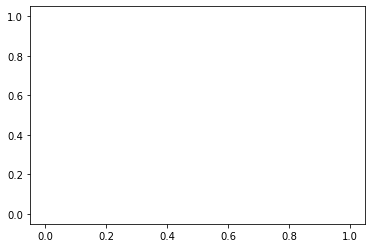

In [23]:
# Evaluation
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list,
                    np.ones(200,)/200, mode='valid'),
        label = 'Running Average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()